<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a two-photon Calcium Imaging dataset. The demo shows how to construct the `params`, `MotionCorrect` and `cnmf` objects and call the relevant functions. You can also run a large part of the pipeline with a single method (`cnmf.fit_file`). See inside for details.

Dataset couresy of Sue Ann Koay and David Tank (Princeton University)

This demo pertains to two photon data. For a complete analysis pipeline for one photon microendoscopic data see demo_pipeline_cnmfE.ipynb</span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in the companion paper. </span></p>
</html>



In [1]:

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import pylab as pl


Loading BokehJS ...

In [48]:
import json
import time
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

### Set up logger (optional)
You can log to a file using the filename parameter, or make the output more or less verbose by setting level to `logging.DEBUG`, `logging.INFO`, `logging.WARNING`, or `logging.ERROR`. A filename argument can also be passed to store the log file

In [2]:
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

### Select file(s) to be processed
The `download_demo` function will download the specific file for you and return the complete path to the file which will be stored in your `caiman_data` directory. If you adapt this demo for your data make sure to pass the complete path to your file(s). Remember to pass the `fname` variable as a list.

In [3]:
# fnames = ['Sue_2x_3000_40_-46.tif']  # filename to be processed
# if fnames[0] in ['Sue_2x_3000_40_-46.tif', 'demoMovie.tif']:
#     fnames = [download_demo(fnames[0])]
#rootdir = '/n/home00/juliana.rhee/caiman_data/testdata_jyr'
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522' #'20190505_JC083'
session_dir = os.path.join(rootdir, animalid, session)

fov = 'FOV1_zoom2p0x'
run_list = ['retino_run2', 'rfs']
run_label = 'retino_run2_rfs'


In [4]:

data_identifier = '|'.join([animalid, session, fov, run_label])

print("*** Dataset: %s ***" % data_identifier)

*** Dataset: JC084|20190522|FOV1_zoom2p0x|retino_run2_rfs ***


In [49]:
fnames = []

for run in run_list:

    fnames_tmp = glob.glob(os.path.join(session_dir, fov, '%s*' % run, 'raw*', '*.tif'))
    fnames.extend(fnames_tmp)
    print("[%s]: added %i tifs to queue." % (run, len(fnames_tmp)))
fnames = sorted(fnames, key=natural_keys)

[retino_run2]: added 12 tifs to queue.
[rfs]: added 66 tifs to queue.


# Save Caiman output to separate dir

In [7]:
results_dir = os.path.join(session_dir, fov, 'caiman_results', run_label)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(results_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs


In [50]:

# dataset dependent parameters
fr = 44.65                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
pw_rigid = False             # flag for performing non-rigid motion correction

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thr = 0.85            # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [2, 2]               # expected half size of neurons in pixels
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
ssub = 1                    # spatial subsampling during initialization
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

In [51]:
opts_dict = {'fnames': fnames,
            'fr': fr,
            'decay_time': decay_time,
            'strides': strides,
            'overlaps': overlaps,
            'max_shifts': max_shifts,
            'max_deviation_rigid': max_deviation_rigid,
            'pw_rigid': pw_rigid,
            'p': 1,
            'nb': gnb,
            'rf': rf,
            'K': K, 
            'stride': stride_cnmf,
            'method_init': method_init,
            'rolling_sum': True,
            'only_init': True,
            'ssub': ssub,
            'tsub': tsub,
            'merge_thr': merge_thr, 
            'min_SNR': min_SNR,
            'rval_thr': rval_thr,
            'use_cnn': True,
            'min_cnn_thr': cnn_thr,
            'cnn_lowest': cnn_lowest}

opts = params.CNMFParams(params_dict=opts_dict)

     2026765 [params.py:                 set():786] [1083] Changing key fnames in group data from None to ['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00001.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00002.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00003.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00004.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00005.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00006.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00007.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00008.tif', '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/raw_6ee6c4/fov1_retinobar_00009.tif', '/

     2026769 [params.py:                 set():786] [1083] Changing key nb in group temporal from 1 to 2
     2026770 [params.py:                 set():786] [1083] Changing key merge_thr in group merging from 0.8 to 0.85
     2026770 [params.py:                 set():786] [1083] Changing key min_SNR in group quality from 2.5 to 2.0
     2026771 [params.py:                 set():786] [1083] Changing key rval_thr in group quality from 0.8 to 0.85
     2026771 [params.py:                 set():786] [1083] Changing key min_cnn_thr in group quality from 0.9 to 0.99
     2026772 [params.py:                 set():786] [1083] Changing key min_SNR in group online from 2.5 to 2.0
     2026772 [params.py:                 set():786] [1083] Changing key rval_thr in group online from 0.8 to 0.85
     2026772 [params.py:                 set():786] [1083] Changing key strides in group motion from (96, 96) to (48, 48)
     2026773 [params.py:                 set():786] [1083] Changing key overlaps in g

In [52]:
results_dir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs'

In [56]:
prefix = 'Yr'
basename = '%s/memmap/%s' % (results_dir, prefix)

In [57]:
total_memmap = glob.glob(os.path.join(results_dir, 'memmap', '%s_d*_.mmap' % prefix))
if len(total_memmap) > 0:
    print("... loading full memmmap")
    fname_new = total_memmap[0]
else:
    #%% MEMORY MAPPING
    # memory map the file in order 'C'
    fname_new = cm.save_memmap(mc.mmap_file, base_name=basename, order='C',
                               border_to_0=border_to_0) # exclude borders
print(fname_new)

... loading full memmmap
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/memmap/Yr_d1_512_d2_512_d3_1_order_C_frames_218922_.mmap


In [58]:

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

# Restart cluster

In [ ]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [ ]:
#%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
opts.change_params({'p': 0})
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit(images)

     8151394 [params.py:                 set():786] [1083] Changing key p in group preprocess from 1 to 0
     8151395 [params.py:                 set():786] [1083] Changing key p in group temporal from 1 to 0
     8151395 [params.py:                 set():786] [1083] Changing key n_processes in group patch from 1 to 8
     8151399 [params.py:                 set():786] [1083] Changing key init_batch in group online from 200 to 218922
     8151399 [params.py:                 set():786] [1083] Changing key medw in group spatial from None to (3, 3)
     8151400 [params.py:                 set():786] [1083] Changing key se in group spatial from None to [[1 1 1]
 [1 1 1]
 [1 1 1]]
     8151401 [params.py:                 set():786] [1083] Changing key ss in group spatial from None to [[1 1 1]
 [1 1 1]
 [1 1 1]]
     8151403 [params.py:                 set():786] [1083] Changing key n_pixels_per_process in group preprocess from None to 158
     8151403 [params.py:                 set():786]

# Re-run seeded nmf

In [ ]:
print(p)

In [ ]:
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
cnm.params.change_params({'p': p})
cnm = cnm.refit(images, dview=dview)

# Save results

In [ ]:
save_results = True
cmm_results_fpath = os.path.join(results_dir, 'cnm_results.hdf5')
if save_results:
    cnm.save(cmm_results_fpath)

# Evaluate components

In [ ]:
# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
min_cnn_thr = 0.99          # threshold for CNN based classifier
cnn_lowest = 0.05           # neurons with cnn probability lower than this value are rejected
#cnm_seeded.estimates.restore_discarded_components()
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': min_cnn_thr,
                           'cnn_lowest': cnn_lowest})

#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

# Extract df_f

In [ ]:
#%% Extract DF/F values
cnm2.estimates.detrend_df_f(quantileMin=8, frames_window=250)

# Look at saved results

In [8]:
from caiman.source_extraction.cnmf.cnmf import load_CNMF


In [9]:
glob.glob(os.path.join(results_dir, '*.hdf5'))

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/cnm_analysis_results.hdf5',
 '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/cnm2_analysis_results.hdf5']

In [28]:
results_fpath = os.path.join(results_dir, 'cnm2_analysis_results.hdf5')
print(results_fpath)
cnm = load_CNMF(results_fpath, n_processes=8)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/cnm2_analysis_results.hdf5


/home/julianarhee/anaconda2/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [30]:
cnm.estimates.A.shape

(262144, 1997)

# Check component quality

In [31]:
cnm.params.quality

{'SNR_lowest': 0.5,
 'cnn_lowest': 0.1,
 'gSig_range': None,
 'min_SNR': 1.2,
 'min_cnn_thr': 0.99,
 'rval_lowest': -1,
 'rval_thr': 0.85,
 'use_cnn': True}

In [32]:
# now load the file
fname_tots = glob.glob(os.path.join(results_dir, 'full_memmap__*.mmap'))
fname_new = fname_tots[0]
print('Full memmapped file: %s' % fname_new)

# Load images
Yr, dims, T = cm.load_memmap(fname_new)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
print(images.shape)

Full memmapped file: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/retino_run2_rfs/full_memmap__d1_512_d2_512_d3_1_order_C_frames_218922_.mmap
(218922, 512, 512)


In [36]:
print("Yr:", Yr.shape)
print("dims:", dims)
print("T:", T)


Yr: (262144, 218922)
dims: (512, 512)
T: 218922


In [38]:
cnm.estimates.b.shape

(262144, 2)

# Set up cluster

In [33]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=8, single_thread=False)

/home/julianarhee/anaconda2/envs/caiman/lib/python3.6/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)
/home/julianarhee/anaconda2/envs/caiman/lib/python3.6/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  res = super(memmap, self).__getitem__(index)
/home/julianarhee/anaconda2/envs/caiman/lib/python3.6/site-packages/numpy/core/memmap.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

In [34]:
# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.85              # space correlation threshold for accepting a component
min_cnn_thr = 0.99          # threshold for CNN based classifier
cnn_lowest = 0.05           # neurons with cnn probability lower than this value are rejected
#cnm_seeded.estimates.restore_discarded_components()
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': rval_thr,
                           'use_cnn': True,
                           'min_cnn_thr': min_cnn_thr,
                           'cnn_lowest': cnn_lowest})

#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)
print(cnm.estimates.A.shape)

     1177144 [params.py:                 set():786] [1083] Changing key min_SNR in group quality from 1.2 to 1.5
     1177145 [params.py:                 set():786] [1083] Changing key cnn_lowest in group quality from 0.1 to 0.05


ValueError: cannot reshape array of size 114850 into shape (446,5,50)

In [39]:
cnm.estimates.A.shape

(262144, 1997)

In [40]:
cnm.estimates.C.shape

(1997, 2233)

In [41]:
cnm.estimates.b.shape

(262144, 2)

In [42]:
cnm.estimates.f.shape

(2, 2233)

In [13]:
#%% Extract DF/F values
fr = 44.65
window_size=30.
frames_window = int(round(fr * window_size))
cnm.estimates.detrend_df_f(quantileMin=8, frames_window=frames_window)

#%% Select only high quality components
cnm.estimates.select_components(use_object=True)

In [15]:
print(cnm.estimates.A.shape)

(262144, 208)


In [22]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
cnm.estimates.Cn = Cn
cnm.estimates.plot_contours_nb(img=Cn)

pl.savefig(os.path.join(results_dir, 'final_components_eval_window30.png'))

KeyboardInterrupt: 

In [103]:
cnm.save(os.path.join(results_dir, 'analysis_results.hdf5'))


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [11]:
print("A:", cnm.estimates.A.shape)
print("C:", cnm.estimates.C.shape)

A: (262144, 208)
C: (208, 26796)


In [39]:
Av = images.mean(axis=0)


In [18]:
cnm.estimates.plot_contours_nb(img=Av)

pl.savefig(os.path.join(results_dir, 'final_components_Av_eval_window3.png'))

<Figure size 432x288 with 0 Axes>

In [20]:
save_movie = False
frame_range = np.arange(0, 2233)

if save_movie:
    # Make save movie:

    # denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
    #                     cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised = cm.movie(cnm.estimates.A.dot(cnm.estimates.C[:, frame_range])).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised.save(os.path.join(results_dir, 'denoised_mov.tif'))


# Align

In [13]:
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

    

In [14]:
import pylab as pl
import matplotlib.gridspec as gridspec


import json
#%pip install pandas
import pandas as pd
#%pip install seaborn
import seaborn as sns


In [15]:
# Get SCAN IMAGE info for run:
# -------------------------------------------------------------------------

run_dir = os.path.join(session_dir, fov, run)

run = os.path.split(run_dir)[-1]
with open(os.path.join(run_dir, '%s.json' % run), 'r') as fr:
    scan_info = json.load(fr)
frame_tsecs = np.array(scan_info['frame_tstamps_sec'])
ntiffs = scan_info['ntiffs']

# Need to make frame_tsecs span all TIFs:
frame_tsecs_ext = np.hstack([frame_tsecs for i in range(ntiffs)])
print(len(frame_tsecs_ext))

nframes_per_file = len(frame_tsecs)


# Load parsed paradigm info:

paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed*.json'))[0]
with open(paradigm_fpath, 'r') as f:
    mwinfo = json.load(f)

conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                       for cond in conditions)
print(trials_by_cond)


trial_nums = np.array([v for k,v in trials_by_cond.items()])
trial_nums = sorted(trial_nums.flatten())


26796


In [17]:
# Get cycle info:

curr_cond = 'left'
stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
stimperiod = 1./stimfreq # sec per cycle

n_frames = scan_info['nvolumes']
fr = scan_info['frame_rate']

n_cycles = int(round((n_frames/fr) / stimperiod))
#print n_cycles

n_frames_per_cycle = int(np.floor(stimperiod * fr))
cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')
print(len(cycle_starts))

12


In [52]:
# Filter out flat liners:

ncomps = cnm.estimates.A.shape[-1]
flat_rois = [rid for rid in range(ncomps) if all(np.diff(cnm.estimates.C[rid])==0)]
print("%i out of %i evaluated components are flat." % (len(flat_rois), ncomps))

print(flat_rois)

# get average traces across condition reps:
active_cells = [i for i in range(ncomps) if i not in flat_rois]
print("N active cells:", len(active_cells))



# Get masks

masks = []
for rid in active_cells:
    msk = np.reshape(cnm.estimates.A[:, rid].toarray(), dims, order='F')
    masks.append(msk)
    
masks = np.array(masks)
print("Mask array:", masks.shape)

0 out of 208 evaluated components are flat.
[]
N active cells: 208
Mask array: (208, 512, 512)


#### Look at 1 roi's traces

# Do FFT analysis


In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from caiman.utils.visualization import plot_contours

import matplotlib as mpl
import matplotlib.cm as cmx
from matplotlib.ticker import MaxNLocator, MultipleLocator, LogFormatter


In [54]:
retino_figdir = os.path.join(results_dir, 'visualization')
if not os.path.exists(retino_figdir):
    os.makedirs(retino_figdir)

#### Do FFT

In [55]:

# label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1/fr))
idx = np.argsort(freqs)
freqs=freqs[idx]
print(freqs)

# exclude DC offset from data
freqs=freqs[int(np.round(n_frames/2.))+1:]

# Identify freq idx:
freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
print("Target freq: %.3f Hz" % freqs[freq_idx])
#max_mod_idx=np.argmax(magnitudes[freq_idx, :],0)#best pixel index


[-22.31640161 -22.29640484 -22.27640806 ...  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


In [56]:
# do fft



def do_fft_analysis(avg_traces, idx, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[idx]
    phase_data = phase_data[idx]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[freq_idx, :]
    phase_array = phase_data[freq_idx, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


In [57]:
#curr_cond = 'bottom'
magratios=[]
phases=[]
conds=[]
traces={}
for curr_cond in trials_by_cond.keys():
    avg_traces = []
    for rid in active_cells:
        tracemat = pd.DataFrame(np.reshape(cnm.estimates.C[rid], (nframes_per_file, ntiffs), order='F'), columns=trial_nums)
        avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
        avg_traces.append(avg)
    avg_traces = pd.DataFrame(np.array(avg_traces).T, columns=active_cells)
    traces[curr_cond] = avg_traces

    magratio_array, phase_array = do_fft_analysis(avg_traces, idx, n_frames)

    magratios.append(magratio_array)
    phases.append(phase_array)
    conds.append(curr_cond)

In [29]:
magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
phases = pd.DataFrame(np.array(phases).T, columns=conds)

In [30]:
ri_mx, ci_mx = np.where(magratios==magratios.max(axis=1).max())
max_mod_ix = int(ri_mx)
max_mod_condn = magratios.columns[int(ci_mx)]
print("max mag ratio ix: %i (cond %s)" % (max_mod_ix, max_mod_condn))

max mag ratio ix: 198 (cond right)


#### Look at 1 cell

(2233,)


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


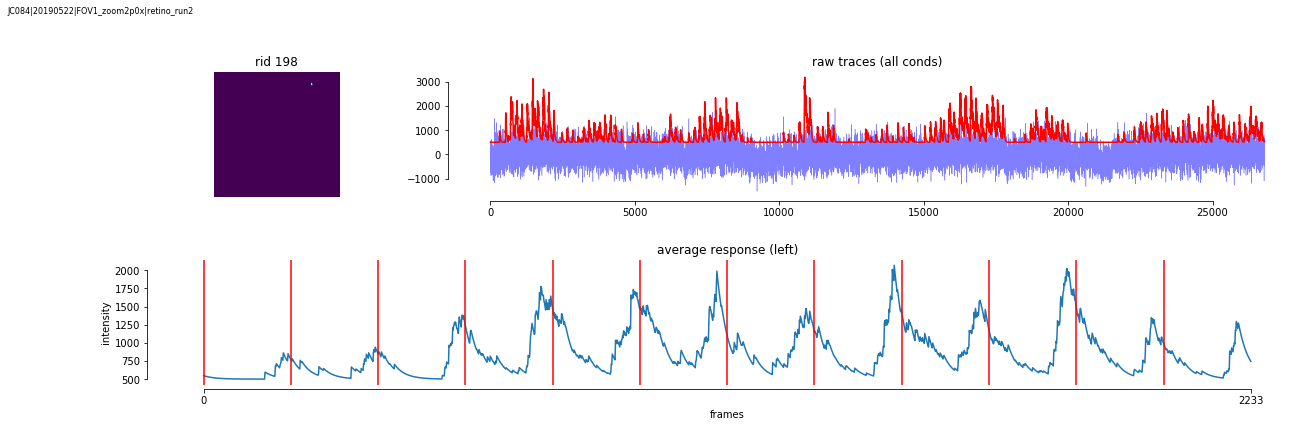

In [31]:
rid = 198 #max_mod_ix
curr_cond = 'left' #max_mod_condn

fig = pl.figure(constrained_layout=True, figsize=(20,6))
gspec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig, height_ratios=[1, 1])

ax1 = fig.add_subplot(gspec[0, 0])
ax1.imshow(np.reshape(cnm.estimates.A[:, rid].toarray(), cnm.dims, order='F'))
ax1.set_title('rid %i' % rid)
ax1.axis('off')

ax2 = fig.add_subplot(gspec[0, 1:])
ax2.plot(cnm.estimates.YrA[rid], 'b', alpha=0.5, lw=0.5)
ax2.plot(cnm.estimates.C[rid], 'r')
ax2.set_title('raw traces (all conds)')

ax3 = fig.add_subplot(gspec[1, 0:])
avg = traces[curr_cond][rid]
print(avg.shape)
ax3.plot(avg)
ax3.set_xticks([0, n_frames])
for cyc in cycle_starts:
    ax3.axvline(x=cyc, color='r')
ax3.set_title('average response (%s)' % curr_cond)
ax3.set_ylabel('intensity')
ax3.set_xlabel('frames')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.85, left=0.1, hspace=0.5)
label_figure(fig, data_identifier)

pl.savefig(os.path.join(retino_figdir, 'funky_cell_%05d_%s.png' % (rid, curr_cond)))

#### Make average denoise movie of 1 cond:

In [32]:
curr_cond = 'left'

print(curr_cond, trials_by_cond[curr_cond])

tot_n_frames = n_frames * len(trial_nums)
assert tot_n_frames == cnm.estimates.C.shape[-1], "Frame counts don't match!"

npix, ncomps = cnm.estimates.A.shape

left [1, 4, 11]


In [33]:
mov = np.empty((npix, n_frames), dtype=cnm.estimates.C.dtype)
for tnum in trials_by_cond[curr_cond]:
    fr_ixs = [fi + ((tnum-1)*n_frames) for fi in np.arange(0, n_frames)]
    mov += cnm.estimates.A.dot(cnm.estimates.C[:, fr_ixs])
mov = mov / len(trials_by_cond[curr_cond])

print(mov.shape)  

(262144, 2233)


In [34]:
save_movie = True

if save_movie:
    # Make save movie:

    # denoised = cm.movie(cnm2.estimates.A.dot(cnm2.estimates.C) + \
    #                     cnm2.estimates.b.dot(cnm2.estimates.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised = cm.movie(mov).reshape(dims + (-1,), order='F').transpose([2, 0, 1])
    denoised.save(os.path.join(retino_figdir, 'denoised_mov_av_%s.tif' % curr_cond))


# Summary figures by condition

In [35]:

def mask_rois(masks, value_array):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)
    
    #masked = np.ma.masked_where(mask == 0, mask)

    
    value_mask =  np.ones(dims)*-100
    for rid in value_array.index.tolist():
        value_mask[masks[rid,:,:]>0] = value_array[rid]

    return value_mask

In [36]:
def plot_overlaid_maps(curr_cond, phases, magratios, mag_thr=0.03):

    phase_array = phases[curr_cond]
    magratio_array = magratios[curr_cond]

    phase_array_cont =  -1 * phase_array
    phase_array_cont = phase_array_cont % (2*np.pi)

    phase_mask_tmp = mask_rois(masks, phase_array_cont)
    magratio_mask_tmp = mask_rois(masks, magratio_array)
    
    phase_mask = np.ma.masked_where(magratio_mask_tmp==-100, phase_mask_tmp)
    magratio_mask = np.ma.masked_where(magratio_mask_tmp==-100, magratio_mask_tmp)
    
    #magratio_mask_thr = np.copy(magratio_mask)
    #magratio_mask_thr[magratio_mask<mag_thr] = np.nan
    magratio_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, magratio_mask)
    print("max magratio:", magratio_array.max())

    #phase_mask_thr = np.copy(phase_mask)
    #phase_mask_thr[magratio_mask<mag_thr] = np.nan
    phase_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, phase_mask)
    print("max phase:", phase_mask_thr.max())


    fig, axes = pl.subplots(1,3, figsize=(12,5))
    ax = axes[0]
    im = ax.imshow(cnm.estimates.Cn, cmap='gray'); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[1]
    axes[1].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(magratio_mask_thr, cmap='inferno', alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[2]
    axes[2].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(phase_mask_thr, cmap='nipy_spectral', vmin=0, vmax=2*np.pi, alpha=0.7); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig


#### Plot figures for each condition

In [37]:
curr_cond = 'left'

max magratio: 0.09184362490232466
max phase: 6.25368875783258


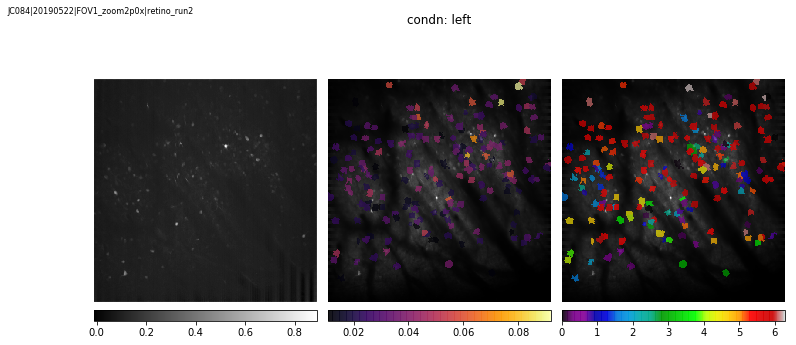

In [44]:
mag_thr = 0.01
fig = plot_overlaid_maps(curr_cond, phases, magratios, mag_thr=mag_thr)
pl.suptitle('condn: %s' % curr_cond)

pl.subplots_adjust(wspace=0.05, left=0.1, top=0.8)
label_figure(fig, data_identifier)
#pl.savefig(os.path.join(retino_figdir, 'overlay_magratio_phase_%s1_magthr%.2f.png' % (curr_cond, mag_thr)))


## View each cell's traces

In [45]:

def plot_sorted_traces(avg_traces, sorted_list, hue_values, hue_label='hue', cmap='cool', 
                       vmin=None, vmax=None, cbar_orientation='vertical', cbar_invert=False, cbar_aspect=False,
                      stimlines=[], ticks_every=0.1, offset=200, figsize=(8, 16), label_rois=False):

    vmin = vmin if vmin is not None else hue_values[sorted_list].min()
    vmax = vmax if vmax is not None else hue_values[sorted_list].max()
    #cnorm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    scalarmap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
    print("scaled cmap lim:", scalarmap.get_clim())

    

    fig, ax = pl.subplots(figsize=figsize)
    #offset = 200
    last_y = 0
    for ri,rid in enumerate(sorted_list):
        cval = scalarmap.to_rgba(hue_values[rid])
        im = ax.plot(avg_traces[rid] + last_y, color=cval, lw=1, alpha=0.8)
        last_y = avg_traces[rid].mean() + ri*offset

    for cyc in stimlines:
        ax.axvline(x=cyc, color='k', linestyle=':', lw=0.75, alpha=0.5)

    sns.despine(trim=True, offset=8, left=True, bottom=True)
    if label_rois:
        ax.set_yticks([ri*offset + avg_traces[rid].mean() for ri,rid in enumerate(sorted_list)])
        ax.set_yticklabels([rid for rid in sorted_list])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.01, top=0.9, right=0.85)

    # colorbar
    bounds = np.linspace(vmin, vmax)
    scalarmap.set_array(bounds)
    if cbar_orientation == 'vertical':
        if cbar_aspect:
            cbar_axes = [0.83, 0.17, 0.14, 0.1]
        else:
            cbar_axes = [0.91, 0.17, 0.02, 0.3]
    else:
        cbar_axes = [0.83, 0.17, 0.14, 0.1]
        
    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
                        ticks=bounds, norm=cnorm, orientation=cbar_orientation) #, format=formatter)
    
    if cbar_orientation == 'vertical':
        ytick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.yaxis.set_major_locator(ytick_locator)
        cbar_ax.set_ylabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_yaxis()
        cbar.ax.axhline(y=-np.pi*elev_cutoff, color='w', lw=2)
        cbar.ax.axhline(y=np.pi*elev_cutoff, color='w', lw=2)
    else:
        xtick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.xaxis.set_major_locator(xtick_locator)
        cbar_ax.set_xlabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_xaxis()


    cbar_ax.axis('off')
    cbar.outline.set_visible(False)
    
    return fig


scaled cmap lim: (-3.141592653589793, 3.141592653589793)


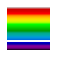

In [142]:
# fig = pl.figure()

# cbar_orientation = 'vertical'
# cbar_axes = [0.87, 0.17, 0.1, 0.15]
# vmin = -np.pi
# vmax = np.pi
# #cnorm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
# cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)


# scalarmap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
# print("scaled cmap lim:", scalarmap.get_clim())
# bounds = np.linspace(vmin, vmax)
# scalarmap.set_array(bounds)


# cbar_ax = fig.add_axes(cbar_axes)
# cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
#                     ticks=bounds, norm=cnorm, orientation=cbar_orientation) #, format=formatter)
# cbar.ax.axhline(y=-np.pi*elev_cutoff, color='w', lw=2)


# cbar_ax.axis('off')
# cbar.outline.set_visible(False)
    

In [35]:
curr_cond

'right'

In [36]:


phase_array = phases[curr_cond]
magratio_array = magratios[curr_cond]

phase_array_cont =  -1 * phase_array
phase_array_cont = phase_array_cont % (2*np.pi)


In [39]:
mag_thr=0.03

thr_rids = magratio_array[magratio_array>=mag_thr].index.tolist()
print("[%s]: %i out of %i pass mag-thr %.2f" % (curr_cond, len(thr_rids), magratio_array.shape[0], mag_thr))


[left]: 86 out of 208 pass mag-thr 0.03


In [40]:
sorted_mags = [i for i in np.argsort(magratio_array)[::-1] if i in thr_rids] # sort high to low
sorted_phase = [i for i in np.argsort(phase_array_cont) if i in thr_rids] # sort smallest to highest

In [144]:
# Check that sorting is correct ---

# for rid in sorted_mags:
#     print(rid, magratio_array[rid])

In [145]:
print(curr_cond)

left


In [146]:
len(sorted_mags)

86

scaled cmap lim: (0.03031319327541995, 0.09184362490232466)
traces_sortby_magratio_left_thr0.03


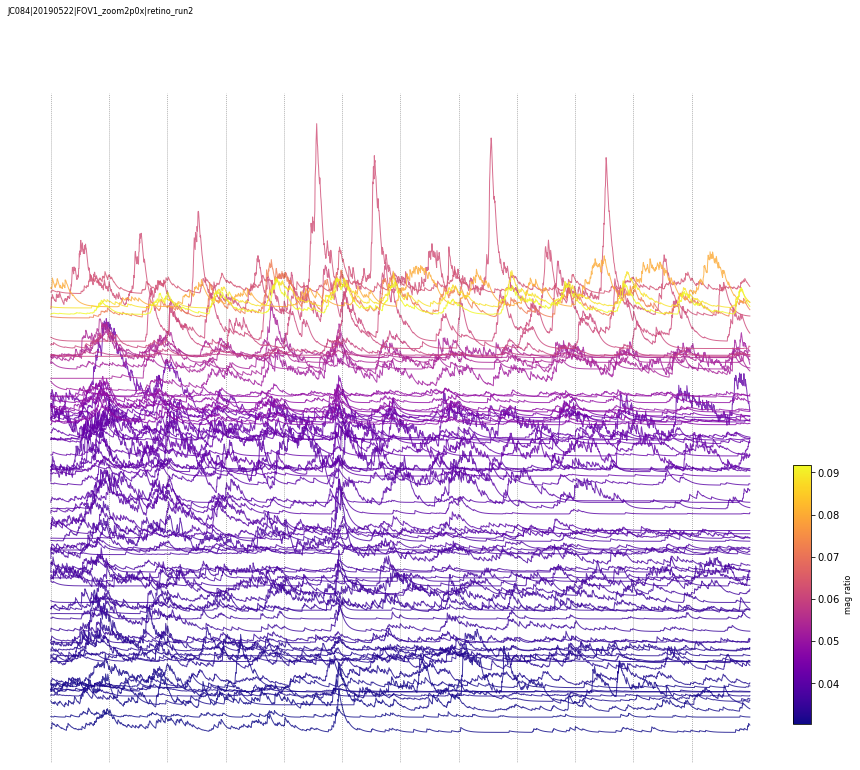

In [147]:
figsize=(12, 12)

cmap = plt.get_cmap('plasma') 
fig = plot_sorted_traces(traces[curr_cond], sorted_mags[::-1], magratio_array, hue_label='mag ratio', 
                         offset=200, cmap=cmap, cbar_aspect=False,
                         stimlines=cycle_starts, ticks_every=0.01, figsize=figsize)

pl.subplots_adjust(left=0.01, top=0.9)
label_figure(fig, data_identifier)

figname = 'traces_sortby_magratio_%s_thr%.2f' % (curr_cond, mag_thr)
pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
print(figname)

In [148]:
curr_cond

'left'

scaled cmap lim: (0.0, 6.283185307179586)
traces_sortby_phase_left_thr0.03


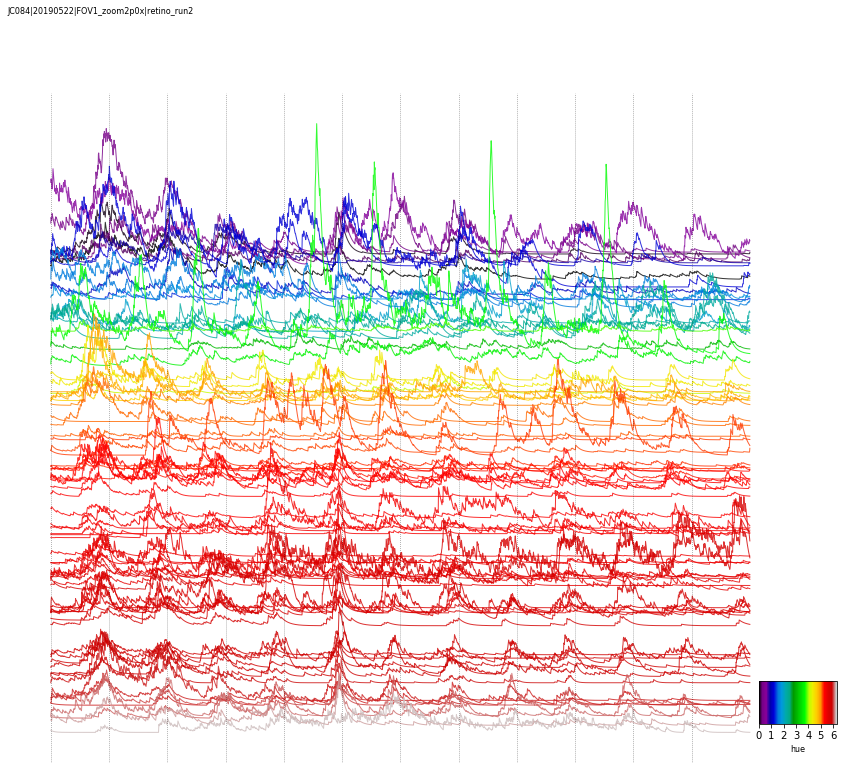

In [149]:
cmap = plt.get_cmap('nipy_spectral') 

cbar_invert = curr_cond in ['right', 'top']
cbar_orientation = 'vertical' if curr_cond in ['top', 'bottom'] else 'horizontal'
cbar_aspect = cbar_orientation == 'vertical'

if curr_cond in ['right', 'bottom']:
    sorted_phase = sorted_phase[::-1]
    
fig = plot_sorted_traces(traces[curr_cond], sorted_phase, phase_array_cont, offset=-200,
                         cmap=cmap, stimlines=cycle_starts, ticks_every=1,
                         cbar_orientation=cbar_orientation, cbar_invert=cbar_invert, cbar_aspect=cbar_aspect,
                         vmin=0, vmax=2*np.pi, figsize=figsize)

label_figure(fig, data_identifier)

figname = 'traces_sortby_phase_%s_thr%.2f' % (curr_cond, mag_thr)
pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
print(figname)

In [150]:
from matplotlib.colors import ListedColormap
cmap = plt.cm.nipy_spectral  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

vmin = 0
vmax = 2*np.pi
cmap = plt.get_cmap('nipy_spectral') 
newcmp = ListedColormap(cmap(np.linspace(vmin, vmax, 8)))


In [151]:
newcmp.get_clim()

AttributeError: 'ListedColormap' object has no attribute 'get_clim'

# Plot by position

In [37]:
phases_cont = -1 * phases
phases_cont = phases_cont % (2*np.pi)

In [38]:
phases_cont.head()


bottom      left     right       top
0  4.036532  5.250579  2.363580  4.258097
1  3.429977  6.112212  1.958841  5.833026
2  6.188916  0.228997  0.372594  2.655650
3  0.999569  6.226110  0.850021  2.182890
4  1.012348  0.003110  0.872284  2.520892

In [39]:
mag_thr=0.03

thr_rids = magratio_array[magratio_array>=mag_thr].index.tolist()
print("[%s]: %i out of %i pass mag-thr %.2f" % (curr_cond, len(thr_rids), magratio_array.shape[0], mag_thr))
print(thr_rids[0:5])

[right]: 102 out of 208 pass mag-thr 0.03
[0, 1, 6, 7, 8]


In [40]:
threshold = True

if threshold:
    phase_df = phases.loc[thr_rids]
else:
    phase_df = phases.copy()
    
print(phase_df.head())
print(phase_df.shape)

     bottom      left     right       top
0  2.246653  1.032607 -2.363580  2.025088
1  2.853208  0.170974 -1.958841  0.450160
6  2.583773  0.804336 -2.523051  1.707561
7  2.189879  0.598918 -2.545714  1.460186
8  2.946815  0.708044 -1.464149 -2.609778
(102, 4)


#### Plot distN of phase for az/el condns

distn_phases_by_cond_86cells_thr0.03


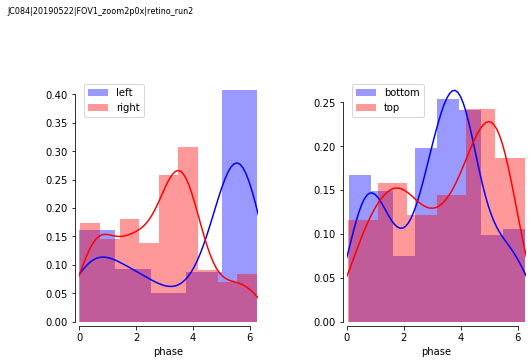

In [169]:
fig, axes = pl.subplots(1,2, figsize=(8,5))

sns.distplot(phases_cont['left'], color='b', label='left', ax=axes[0])
sns.distplot(phases_cont['right'], color='r', label='right', ax=axes[0])
axes[0].legend()
axes[0].set_xlabel('phase')
axes[0].set_xlim([0, 2*np.pi])

sns.distplot(phases_cont['bottom'], color='b', label='bottom', ax=axes[1])
sns.distplot(phases_cont['top'], color='r', label='top', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('phase')
axes[1].set_xlim([0, 2*np.pi])

sns.despine(trim=True, offset=4)
pl.subplots_adjust(wspace=0.5, top=0.8)

label_figure(fig, data_identifier)

if threshold:
    figname = 'distn_phases_by_cond_%icells_thr%.2f' % (len(thr_rids), mag_thr)
else:
    figname = 'distn_phases_by_cond_%icells_nothr' % len(thr_rids)
    
pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
print(figname)

### Get screen limits

In [86]:

# adjust elevation limit to show only monitor extent
screeninfo_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi_maps', '*.json'))[0]
with open(screeninfo_fpath, 'r') as f:
    screen = json.load(f)

screen_width = screen['screen_params']['screen_size_x_degrees']
screen_height = screen['screen_params']['screen_size_t_degrees']




screen_left = -1*screen_width/2.
screen_right = screen_width/2.
screen_top = screen_height/2.
screen_bottom = -1*screen_height/2.
    
elev_cutoff = screen_top / screen_right
print("[AZ]: screen bounds: (%.2f, %.2f)" % (screen_left, screen_right))
print("[EL]: screen bounds: (%.2f, %.2f)" % (screen_top, screen_bottom))


[AZ]: screen bounds: (-58.78, 58.78)
[EL]: screen bounds: (33.66, -33.66)


In [87]:
elev_cutoff

0.5726770694395296

### Set threshold for cells that meet min mag-thr across ALL conditions:

In [149]:
mag_thr = 0.03
all_conds_pass = True

if all_conds_pass:
    strong_cells = [i for i in magratios.index.tolist() if all(magratios.iloc[i]>=mag_thr)]
else:
    strong_cells = [i for i in magratios.index.tolist() if any(magratios.iloc[i]>=mag_thr)]

# mag_thr = 0.05
# strong_cells = np.where(magratios.min(axis=1) > mag_thr)[0]
# strong_cells

print("%i out of %i cells meet min mag-thr of %.2f for all conds." % (len(strong_cells), magratios.shape[0], mag_thr))

32 out of 208 cells meet min mag-thr of 0.03 for all conds.


In [150]:
use_cont = True
filter_by_mag = True

if use_cont:
    elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
    azim = (phases_cont['left'] - phases_cont['right']) / 2.

    vmin = -np.pi
    vmax = np.pi
    
else:
    elev = (phases['bottom'] - phases['top']) / 2.
    azim = (phases['left'] - phases['right']) / 2.

    elev_c = -1 * elev
    elev_c = elev_c % (2*np.pi)

    azim_c = -1 * azim
    azim_c = azim_c % (2*np.pi)

    vmin = 0
    vmax = 2*np.pi
    
    azim = copy.copy(azim_c)
    elev = copy.copy(elev_c)

magratios_all = magratios.mean(axis=1)
    
if filter_by_mag:
    azim_phase = mask_rois(masks, azim[strong_cells])
    elev_phase = mask_rois(masks, elev[strong_cells])
else:
    azim_phase = mask_rois(masks, azim)
    elev_phase = mask_rois(masks, elev)

azim_phase_mask = np.ma.masked_where(azim_phase==-100, azim_phase)
elev_phase_mask = np.ma.masked_where(elev_phase==-100, elev_phase)

    

In [167]:
[i for i in elev[strong_cells] if i > np.pi*elev_cutoff or i < -np.pi*elev_cutoff]

[2.052142354206125, 2.1448365289458264]

In [168]:
elev[strong_cells]

7     -0.364846
8      0.363296
15    -0.706359
26    -0.455453
31    -0.980587
34    -0.690378
44    -0.576979
61    -0.692196
66    -0.547310
74    -0.286179
75    -0.285839
76    -0.503168
80     2.052142
88    -0.403490
90    -0.849271
100   -0.005980
105   -0.395138
106   -0.530895
109   -1.343476
122   -1.072350
139   -0.448244
146   -0.381594
152   -0.978078
154   -1.155829
177   -1.127726
180   -0.913242
185    2.144837
186   -0.460924
196   -1.266359
198   -1.093158
202   -0.939131
206   -0.528745
dtype: float64

phase_to_screencoords_magthr_0.030


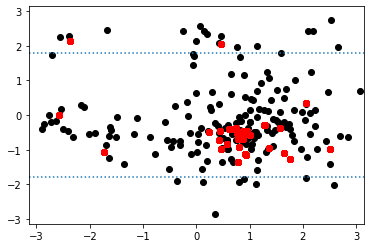

In [151]:
fig, ax = pl.subplots() #pl.figure()
ax.scatter(azim, elev, c='k')
ax.scatter(azim_phase, elev_phase, c='r')
ax.set_xlim([vmin, vmax])
ax.set_ylim([vmin, vmax])

ax.axhline(y=np.pi*elev_cutoff, linestyle=':')
ax.axhline(y=-np.pi*elev_cutoff, linestyle=':')

if filter_by_mag:
    figname = 'phase_to_screencoords_magthr_%.3f' % mag_thr
else:
    figname = 'phase_to_screencoords_all'
pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
print(figname)

absolute_maps_filter_allconds_magthr_0.03_32cells


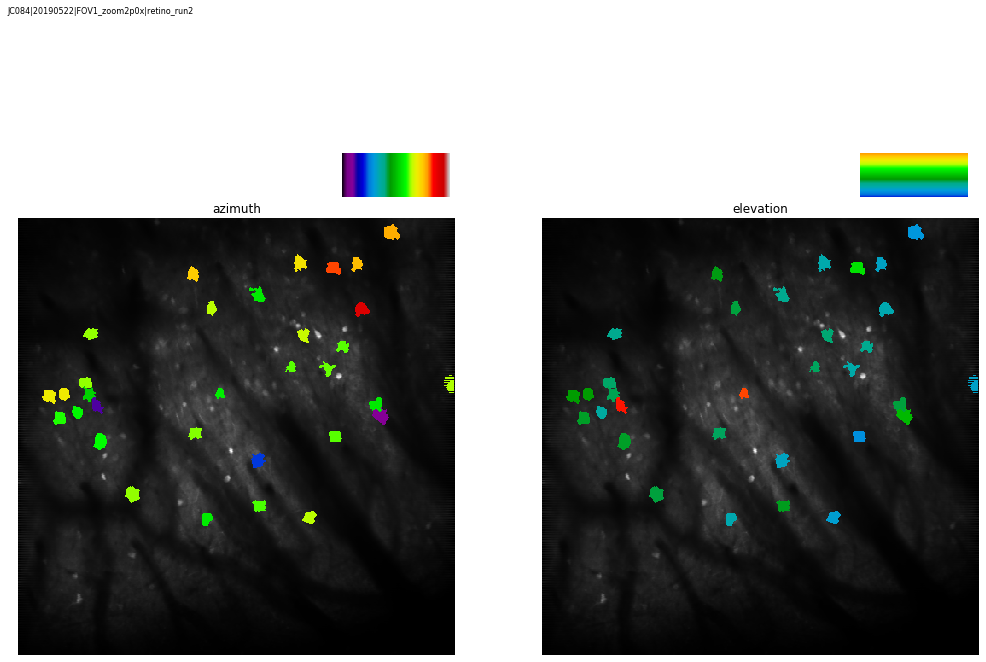

In [152]:
# # mask some 'bad' data, in your case you would have: data == 0
# np.where(elev_phase != np.nan)
# elev_masked = np.ma.masked_where(elev_phase < -np.pi*elev_cutoff, elev_phase)
# elev_masked = np.ma.masked_where(elev_masked > np.pi*elev_cutoff, elev_masked)

# cmapE = pl.cm.nipy_spectral
# cmapE.set_bad(color='gray')

# colorbar
# cmap = 'nipy_spectral'
# cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# bounds = np.linspace(vmin, vmax)
# ticks_every=1.0
# hue_label=''

import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin, vmax)

fig, axes = pl.subplots(1,2, figsize=(15, 12))
# -- azimuth --
ax = axes[0]
ax.imshow(Av, cmap='gray'); ax.axis('off');
im1 = ax.imshow(azim_phase_mask, cmap='nipy_spectral', norm=norm, vmin=vmin, vmax=vmax) #, alpha=0.7)
ax.set_title('azimuth')

# -- elevation --
ax = axes[1]
ax.imshow(Av, cmap='gray'); ax.axis('off');
im2 = ax.imshow(elev_phase_mask, cmap='nipy_spectral', norm=norm, vmin=vmin, vmax=vmax) #, alpha=0.7)
ax.set_title('elevation')



cbar1_orientation='horizontal'
cbar1_axes = [0.31, 0.78, 0.1, 0.05]
cbar2_orientation='vertical'
cbar2_axes = [0.79, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
cb2.ax.set_ylim(-np.pi*elev_cutoff, np.pi*elev_cutoff)
cb2.ax.axis('off')
cb2.outline.set_visible(False)

pl.subplots_adjust(left=0.01, right=0.9)

if filter_by_mag:
    if all_conds_pass:
        figname = 'absolute_maps_filter_allconds_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
    else:
        figname = 'absolute_maps_filter_maxcond_magthr_%.2f_%icells' % (mag_thr, len(strong_cells))
else:
    figname = 'absolute_maps_all_cells'

label_figure(fig, data_identifier)
pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))

print(figname)

#### Plot traces for best cells

In [153]:
curr_cond

'right'

In [154]:
#azim_thr = [azim[r] for r in strong_cells]
#elev_thr = [azim[r] for r in strong_cells]
#magratio_thr = [magratios.max(axis=1)[r] for r in strong_cells]

sorted_phase_abs_azim = [i for i in np.argsort(azim)[::-1] if i in strong_cells]
sorted_phase_abs_elev = [i for i in np.argsort(elev)[::-1] if i in strong_cells]
sorted_magratio_abs = [i for i in np.argsort(magratios_all)[::-1] if i in strong_cells]



In [155]:
for rid in sorted_magratio_abs[0:10]:
    print(rid, magratios_all[rid])

196 0.08041154725017283
202 0.07925547549200465
198 0.07765068433566101
105 0.07687504972835361
206 0.07608376959135074
180 0.07177060344057011
152 0.0708531607115931
15 0.06271587516561965
122 0.060287434356525185
186 0.057406371181249985


In [156]:
magratios_all[sorted_magratio_abs]

196    0.080412
202    0.079255
198    0.077651
105    0.076875
206    0.076084
180    0.071771
152    0.070853
15     0.062716
122    0.060287
186    0.057406
44     0.055567
75     0.054838
61     0.052839
88     0.052789
7      0.052532
154    0.050588
139    0.050557
26     0.049706
177    0.048125
80     0.046386
31     0.045358
8      0.045261
109    0.044350
34     0.043967
146    0.043958
106    0.042262
76     0.041524
74     0.040998
66     0.040350
100    0.040024
90     0.038460
185    0.033592
dtype: float64

In [157]:

# figsize=(12, 12)

# cmap = plt.get_cmap('plasma') 
# fig = plot_sorted_traces(traces[curr_cond], sorted_magratio_abs, magratios_all, offset=-200,
#                          cmap=cmap, stimlines=cycle_starts, ticks_every=0.01, figsize=figsize,
#                         label_rois=True)
#                          #vmin=-np.pi, vmax=np.pi,
#                          #cbar_orientation=cbar_orientation, cbar_invert=cbar_invert, cbar_aspect=cbar_aspect)

# label_figure(fig, data_identifier)


# if filter_by_mag:
#     if all_conds_pass:
#         figname = 'waterfall_sortby_magratioABS__allconds_magthr_%.2f_%icells_%s' % (mag_thr, len(strong_cells), curr_cond)
#     else:
#         figname = 'waterfall_sortby_magratioABS__maxcond_magthr_%.2f_%icells_%s' % (mag_thr, len(strong_cells), curr_cond)
# else:
#     figname = 'waterfall_sortby_magratioABS__allcells'
    

# #figname = 'sortby_magratio_traces_%s_top%i_magthr%.2f' % (curr_cond, len(strong_cells), mag_thr)
# #pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
# print(figname)


scaled cmap lim: (-3.141592653589793, 3.141592653589793)
waterfall_sortby_phaseABS__allconds_magthr_0.03_32cells_bottom


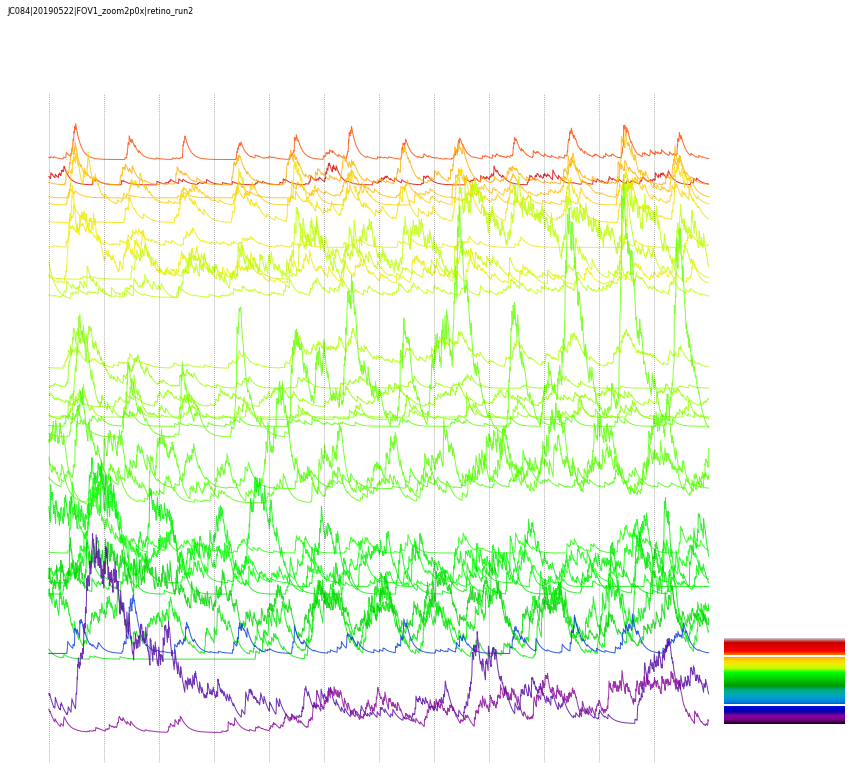

In [161]:

curr_cond = 'bottom'

cmap = plt.get_cmap('nipy_spectral') 

cbar_invert = False
cbar_orientation = 'vertical' if curr_cond in ['top', 'bottom'] else 'horizontal'
cbar_aspect = cbar_orientation == 'vertical'

fig = plot_sorted_traces(traces[curr_cond], sorted_phase_abs_azim, azim, offset=-400,
                         cmap=cmap, stimlines=cycle_starts, ticks_every=1,
                         vmin=-np.pi, vmax=np.pi, figsize=figsize, 
                         cbar_orientation=cbar_orientation, cbar_invert=cbar_invert, cbar_aspect=cbar_aspect)

label_figure(fig, data_identifier)

#figname = 'sortby_phase_traces_%s_top%i_magthr%.2f' % (curr_cond, len(strong_cells), mag_thr)

if filter_by_mag:
    if all_conds_pass:
        figname = 'waterfall_sortby_phaseABS__allconds_magthr_%.2f_%icells_%s' % (mag_thr, len(strong_cells), curr_cond)
    else:
        figname = 'waterfall_sortby_phaseABS__maxcond_magthr_%.2f_%icells_%s' % (mag_thr, len(strong_cells), curr_Cond)
else:
    figname = 'waterfall_sortby_phaseABS__allcells'
    

pl.savefig(os.path.join(retino_figdir, '%s.png' % figname))
print(figname)


### Look at 1 cycle

In [485]:
curr_cond = 'top'

tracemat = np.array(traces[curr_cond].values)

mean_cycle = tracemat[cycle_starts[0]:cycle_starts[0]+n_frames_per_cycle]
for cyc in cycle_starts[1:]:
    mean_cycle += (tracemat[cyc:cyc+n_frames_per_cycle])
mean_cycle = mean_cycle / float(n_cycles)

In [502]:
top_cells = np.argsort(magratios.max(axis=1)[strong_cells])[::-1]

In [503]:
top_cells

298    44
294    34
290    23
288    40
277    45
276    43
271    46
267    13
258     4
248    27
243    20
232    37
229    42
218    15
216    30
208     9
207     0
196    18
184    31
179    10
162     3
161    25
156    35
155    36
152     7
149     2
138    38
136     1
134    33
125    22
119    29
118    17
116    28
103    39
101    12
94      6
93     11
73      5
61     26
55     16
48     32
44      8
30     14
21     24
19     21
18     19
2      41
dtype: int64

In [532]:
for rid in sorted_magratio_abs: #top_cells.index.tolist():
    print(rid, magratio_thr[rid])

44 0.10427009096773984
34 0.10107093448750136
23 0.09963550330813074
40 0.09513737135794062
45 0.09220753042553323
43 0.09184362490232466
46 0.08708909484064428
13 0.08653754143103311
4 0.08100665455341606
27 0.07729608077879155
20 0.0744584043915925
37 0.07376151353694295
42 0.0734331273572946
15 0.07319203126003153
30 0.07303469324529054
9 0.07178927670153848
0 0.07149767612476964
18 0.07134966699722362
31 0.07047569467940276
10 0.0703529022627143
3 0.06982611629035397
25 0.06838376200705423
35 0.06802964088842739
36 0.06687802432583445
7 0.06479664026401223
2 0.06394405960196582
38 0.06376002109322437
1 0.06342413393146465
33 0.06173024950424936
22 0.06122274171543486
29 0.05794035040178379
17 0.05662624293894317
28 0.055880172290516124
39 0.05516609396932594
12 0.05378713532326054
6 0.05354582219138916
11 0.053376061535329755
5 0.0526992443343587
26 0.05061655705786966
16 0.05011692868479862
32 0.04990762738410656
8 0.04785958771869824
14 0.046722627177788266
24 0.04549905846929945

In [533]:
strong_cells[44]

290

In [537]:
sorter

array([44, 34, 23, 40, 45, 43, 46, 13,  4, 27, 20, 37, 42, 15, 30,  9,  0,
       18, 31, 10,  3, 25, 35, 36,  7,  2, 38,  1, 33, 22, 29, 17, 28, 39,
       12,  6, 11,  5, 26, 16, 32,  8, 14, 24, 21, 19, 41])

scaled cmap lim: (-3.141592653589793, 3.141592653589793)


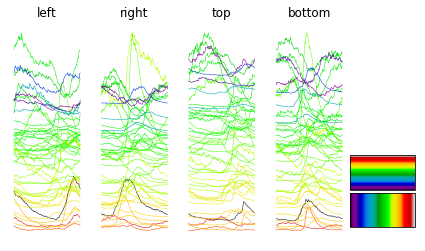

In [856]:
sort_by_mag = False

fig, axes = pl.subplots(1, 4, figsize=(6,4))

if sort_by_mag:
    vmin = min(magratios_all)
    vmax = max(magratios_all)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarmap = cmx.ScalarMappable(norm=cnorm, cmap='plasma')
    sorter = np.copy(sorted_magratio_abs)
    hue_values = np.copy(magratios_all)
    ticks_every=0.02
    hue_label = ''
    cbar_orientation='vertical'
    cbar_axes = [0.91, 0.17, 0.02, 0.3]
    cbar_axes2 = None
else:
    vmin = -np.pi
    vmax = np.pi
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarmap = cmx.ScalarMappable(norm=cnorm, cmap='nipy_spectral')
    sorter = np.copy(sorted_phase_abs_azim)
    hue_values = np.copy(azim)
    ticks_every=1.0
    hue_label = 'phase'
    cbar_orientation='horizontal'
    cbar_axes = [0.91, 0.17, 0.15, 0.12]
    cbar_axes2 = [0.91, 0.30, 0.15, 0.12]
    
print("scaled cmap lim:", scalarmap.get_clim())
offset = 50


for ci,curr_cond in enumerate(['left', 'right', 'top', 'bottom']): #enumerate(trials_by_cond.keys()):
    tracemat = np.array(traces[curr_cond].values)
    mean_cycle = tracemat[cycle_starts[0]:cycle_starts[0]+n_frames_per_cycle]
    for cyc in cycle_starts[1:]:
        mean_cycle += (tracemat[cyc:cyc+n_frames_per_cycle])
    mean_cycle = mean_cycle / float(n_cycles)
    
    ax = axes[ci]
    for ri, rid in enumerate(sorter): #enumerate(sorted_phase_abs):
        if rid == 290:
            cval = 'k'
        else:
            cval = scalarmap.to_rgba(hue_values[rid])
        ax.plot(mean_cycle[:, rid] + ri*offset, color=cval, lw=0.5)
    ax.set_title(curr_cond)
    
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_xticklabels([]); ax.set_yticklabels([]);

# colorbar

bounds = np.linspace(vmin, vmax)
scalarmap.set_array(bounds)

cbar_ax = fig.add_axes(cbar_axes)
cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
                    ticks=[], norm=cnorm, orientation=cbar_orientation) #, format=formatter)
if cbar_orientation == 'vertical':
    ytick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
    cbar_ax.yaxis.set_major_locator(ytick_locator)
    cbar_ax.set_ylabel('%s' % hue_label, fontsize=8)
    if cbar_invert:
        cbar_ax.invert_yaxis()
else:
    cbar_ax.set_xticks([])
    cbar_ax.set_xticklabels([])
    if cbar_axes2 is not None:
        cbar_ax = fig.add_axes(cbar_axes2)
        cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
                            ticks=[], norm=cnorm, orientation='vertical') #, format=formatter)

sns.despine(left=True, bottom=True)


# Movies

In [857]:
import tifffile as tf

In [1045]:
curr_cond = 'top'


In [1046]:
mov_fpath = os.path.join(results_dir, 'denoised_mov_av_%s.tif' % curr_cond)
mov = tf.imread(mov_fpath)
n_fr, d1, d2 = mov.shape

In [1047]:
mw_start_ixs = mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['start_indices']

mwpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'][0:mw_start_ixs[1]])
len(mwpos)
mwpos = mwpos - mwpos.min()

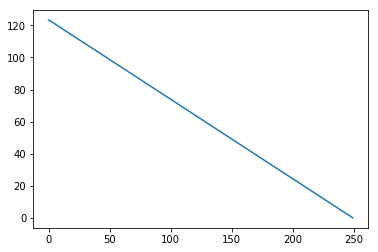

In [1049]:
pl.plot(mwpos)

In [1050]:

iframes = np.linspace(mwpos[0], mwpos[-1], n_frames_per_cycle)

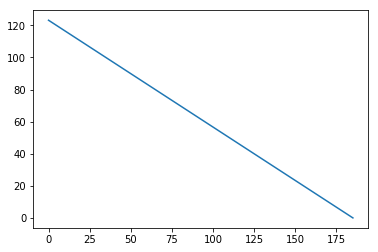

In [1051]:
pl.plot(iframes)

In [1052]:
iframes[0:n_frames_per_cycle]

array([123.22000122, 122.55394716, 121.8878931 , 121.22183904,
       120.55578498, 119.88973092, 119.22367686, 118.5576228 ,
       117.89156874, 117.22551467, 116.55946061, 115.89340655,
       115.22735249, 114.56129843, 113.89524437, 113.22919031,
       112.56313625, 111.89708219, 111.23102813, 110.56497407,
       109.89892001, 109.23286595, 108.56681189, 107.90075783,
       107.23470377, 106.5686497 , 105.90259564, 105.23654158,
       104.57048752, 103.90443346, 103.2383794 , 102.57232534,
       101.90627128, 101.24021722, 100.57416316,  99.9081091 ,
        99.24205504,  98.57600098,  97.90994692,  97.24389286,
        96.57783879,  95.91178473,  95.24573067,  94.57967661,
        93.91362255,  93.24756849,  92.58151443,  91.91546037,
        91.24940631,  90.58335225,  89.91729819,  89.25124413,
        88.58519007,  87.91913601,  87.25308195,  86.58702788,
        85.92097382,  85.25491976,  84.5888657 ,  83.92281164,
        83.25675758,  82.59070352,  81.92464946,  81.25

In [1053]:
#stimsize = int(round(iframes.max()))

allpos = np.array(mwinfo['%i' % trials_by_cond[curr_cond][0]]['stiminfo']['values'])
stimsize = int(np.ceil(allpos.max() - allpos.min()))
print(stimsize)

#stimsize = len(iframes)

124


0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1


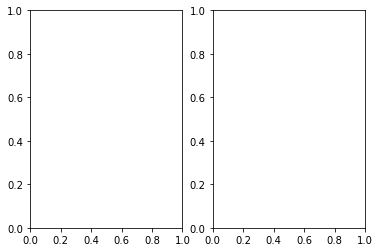

In [1054]:
fig, ax = pl.subplots(1,2)
stimulus = np.zeros((stimsize, stimsize), dtype=np.int8)
if curr_cond in ['left', 'right']:
    stimulus[:, 0:2] = 255
else:
    stimulus[0:2, :] = 255
    
iframes = [int(round(i)) for i in iframes]
pos_int = 0
stim_list=[]
for fi, fpos in enumerate(iframes):
    stimulus = np.roll(stimulus, pos_int, axis=0)
    if fi < len(iframes)-1:
        pos_int = abs(iframes[fi+1] - fpos)
    print(pos_int)
    stim_list.append(stimulus)

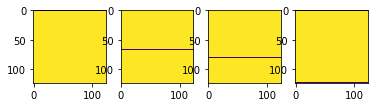

In [1055]:
fig, ax = pl.subplots(1,4)
ax[0].imshow(stim_list[0])
ax[1].imshow(stim_list[100])
ax[2].imshow(stim_list[120])
ax[3].imshow(stim_list[185])


In [1056]:
stim_mov = np.array(stim_list)
full_stim_mov = np.vstack([stim_mov for _ in range(n_cycles)])
stim_mov_fpath = '%s_stimulus.tif' % os.path.splitext(mov_fpath)[0]
tf.imsave(stim_mov_fpath, full_stim_mov)


In [1008]:
os.path.splitext(mov_fpath)

('/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results/denoised_mov_av_right',
 '.tif')

In [1025]:
stim_mov.shape

(186, 124, 124)

In [1032]:
np.vstack([stim_mov for _ in range(n_cycles)])

(2232, 124, 124)